<a href="https://colab.research.google.com/github/andreidore/aicrowd_blitz_may_2020/blob/master/minileaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install wandb==0.8.33


In [9]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt

--2020-05-09 12:14:42--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.16, 130.117.252.13, 130.117.252.11, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133527680 (127M) [binary/octet-stream]
Saving to: ‘train-images.npy.2’

train-images.npy.2  100%[===================>] 127.34M  46.7MB/s    in 2.7s    

2020-05-09 12:14:45 (46.7 MB/s) - ‘train-images.npy.2’ saved [133527680/133527680]

--2020-05-09 12:14:46--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.16, 130.117.252.13, 130.117.252.11, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.11

In [0]:
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import wandb
from wandb.keras import WandbCallback

In [11]:
wandb.init(name='CNN', project="minileaves",config={"hyper": "parameter"})

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/andrei-dore/minileaves/runs/3eas97kl

## Import data

In [0]:
train_images_path = "train-images.npy" #path where data is stored
train_labels_path = "train-labels.npy"

train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path)

# Load Class mapping
class_names = [x.strip() for x in open("all_classes.txt").readlines()]

In [13]:
print(train_images.shape)
print(train_labels.shape)
print(train_labels[0:10])
print(class_names)


(43466, 32, 32, 3)
(43466,)
[ 7  4  9 29 20 15 37  5 29 28]
['apple-apple-scab', 'apple-black-rot', 'apple-cedar-apple-rust', 'apple-healthy', 'blueberry-healthy', 'cherry-including-sour-healthy', 'cherry-including-sour-powdery-mildew', 'corn-maize-cercospora-leaf-spot-gray-leaf-spot', 'corn-maize-common-rust', 'corn-maize-healthy', 'corn-maize-northern-leaf-blight', 'grape-black-rot', 'grape-esca-black-measles', 'grape-healthy', 'grape-leaf-blight-isariopsis-leaf-spot', 'orange-haunglongbing-citrus-greening', 'peach-bacterial-spot', 'peach-healthy', 'pepper-bell-bacterial-spot', 'pepper-bell-healthy', 'potato-early-blight', 'potato-healthy', 'potato-late-blight', 'raspberry-healthy', 'soybean-healthy', 'squash-powdery-mildew', 'strawberry-healthy', 'strawberry-leaf-scorch', 'tomato-bacterial-spot', 'tomato-early-blight', 'tomato-healthy', 'tomato-late-blight', 'tomato-leaf-mold', 'tomato-septoria-leaf-spot', 'tomato-spider-mites-two-spotted-spider-mite', 'tomato-target-spot', 'tomato-

## Visualize date

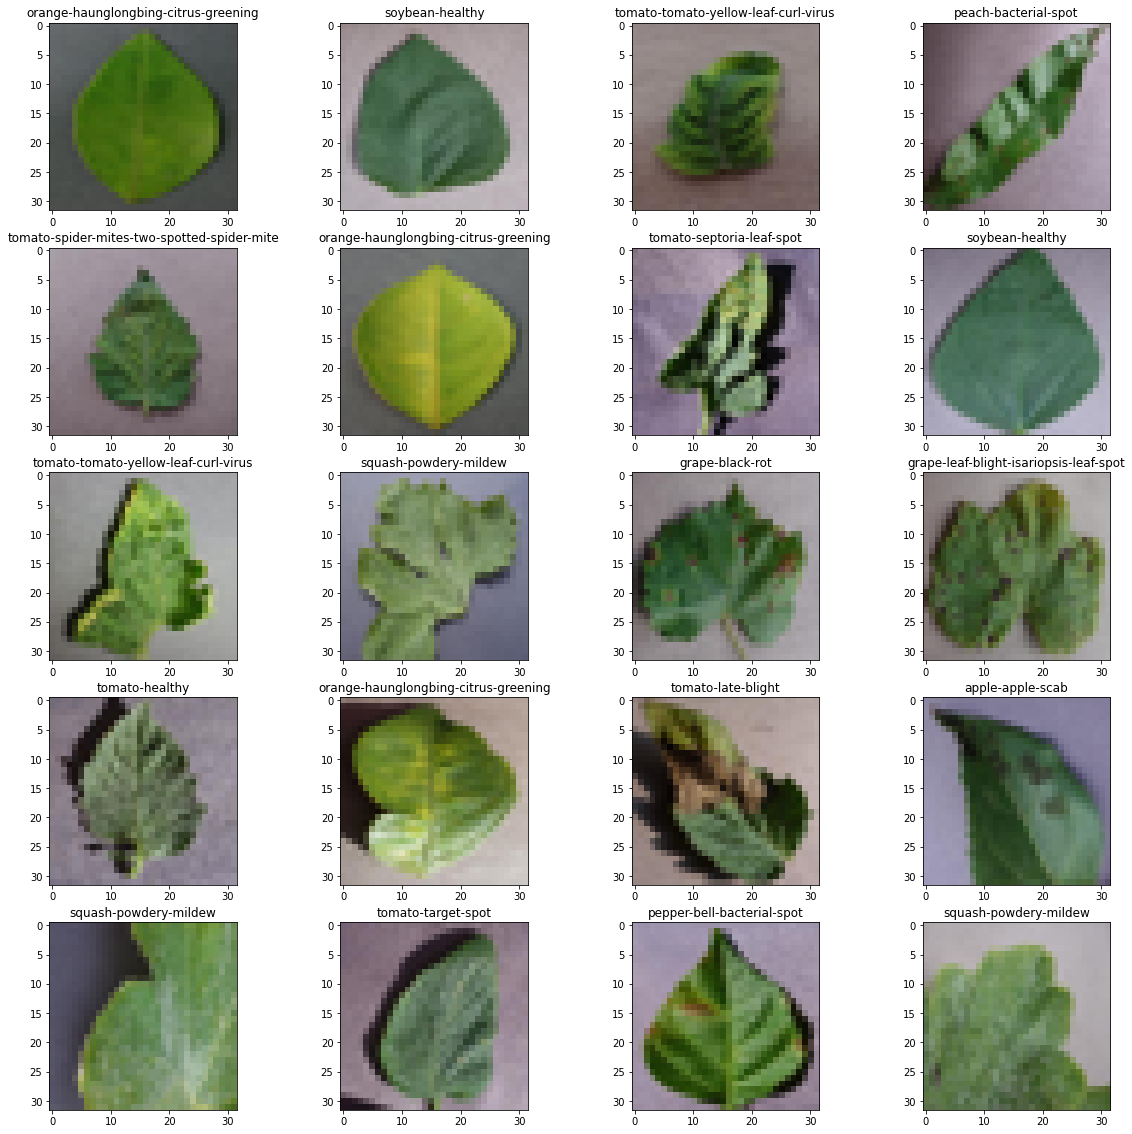

In [14]:
def random_data_sample():
    """
    Returns a random data sample from the training set
    """
    random_index = np.random.randint(0, train_images.shape[0])
    # Render the image
    image_array = train_images[random_index]
    class_label = train_labels[random_index] # an integral number in [0-38)
    class_name = class_names[class_label] # a human readable class name
    return image_array, class_label, class_name



fig=plt.figure(figsize=(20, 20))
w=10
h=10
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    image,class_label,class_name=random_data_sample()
    plt.imshow(image)
    plt.title(class_name)

## Distribution

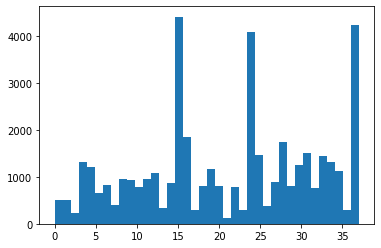

In [15]:
#data_counter = Counter(train_labels)
#unique_class_indices = data_counter.keys()

#for _class_index in unique_class_indices:
#    print("Class Index : ", _class_index)
#    print("Class Name : ", class_names[_class_index])
#    print("Number of images in the dataset : ", data_counter[_class_index])
#    print("="*100)



plt.hist(train_labels, bins = 38)
plt.show()


In [0]:
X_train, X_val= train_test_split(train_images, test_size=0.2, random_state=42)
y_train, y_val= train_test_split(train_labels, test_size=0.2, random_state=42)

In [17]:
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255


# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)


# print shape of training set
print('x_train shape:', X_train.shape)

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')


x_train shape: (34772, 32, 32, 3)
34772 train samples
8694 validation samples


In [18]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0

In [19]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

model_checkpoint=ModelCheckpoint(filepath="best_model.hdf5",verbose=1,save_best_only=True)
wand_callback=WandbCallback()


history=model.fit(x=X_train,y=y_train,batch_size=32,epochs=30,verbose=2,
          callbacks=[model_checkpoint,wand_callback],validation_data=(X_val,y_val),shuffle=True)

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.14836, saving model to best_model.hdf5
1087/1087 - 5s - loss: 1.7591 - accuracy: 0.5072 - val_loss: 1.1484 - val_accuracy: 0.6674
Epoch 2/30

Epoch 00002: val_loss improved from 1.14836 to 0.59052, saving model to best_model.hdf5
1087/1087 - 5s - loss: 0.9176 - accuracy: 0.7231 - val_loss: 0.5905 - val_accuracy: 0.8245
Epoch 3/30

Epoch 00003: val_loss improved from 0.59052 to 0.56794, saving model to best_model.hdf5
1087/1087 - 5s - loss: 0.7182 - accuracy: 0.7788 - val_loss: 0.5679 - val_accuracy: 0.8252
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.56794
1087/1087 - 5s - loss: 0.6070 - accuracy: 0.8131 - val_loss: 0.6172 - val_accuracy: 0.8068
Epoch 5/30

Epoch 00005: val_loss improved from 0.56794 to 0.55198, saving model to best_model.hdf5
1087/1087 - 5s - loss: 0.5362 - accuracy: 0.8333 - val_loss: 0.5520 - val_accuracy: 0.8277
Epoch 6/30

Epoch 00006: val_loss improved from 0.55198 to 0.38140, saving model to be

In [0]:
model.load_weights('best_model.hdf5')

In [22]:
scores = model.evaluate(X_val, y_val, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

68/68 [==============================] - 0s 3ms/step - loss: 0.2615 - accuracy: 0.9206

Test result: 92.063 loss: 0.261


In [0]:
test_file_path = "test-images.npy"
test_images = np.load(test_file_path)

In [0]:
test_images=test_images.astype('float32')/255

In [0]:
submission=model.predict(test_images)

In [33]:

submission=np.argmax(submission,axis=1)
print(submission.shape)

(10838,)


## Save the prediction to csv

In [0]:
import pandas as pd
submission = pd.DataFrame(submission)
submission.to_csv('submission.csv',header=['class_index'],index=False)

## To download the generated csv in colab run the below command

In [0]:
from google.colab import files
files.download('submission.csv')